## Eunjoo and Eryk's Housing Price Bakery

Baking King County's sweetest housing price desserts since 2014.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as st
import math

import pickle

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Step 1: Read in Data

In [2]:
house_train = pd.read_csv('data/kc_house_data_train.csv', index_col = 0)
#house_train.head()

In [3]:
house_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
id               17290 non-null int64
date             17290 non-null object
price            17290 non-null float64
bedrooms         17290 non-null int64
bathrooms        17290 non-null float64
sqft_living      17290 non-null int64
sqft_lot         17290 non-null int64
floors           17290 non-null float64
waterfront       17290 non-null int64
view             17290 non-null int64
condition        17290 non-null int64
grade            17290 non-null int64
sqft_above       17290 non-null int64
sqft_basement    17290 non-null int64
yr_built         17290 non-null int64
yr_renovated     17290 non-null int64
zipcode          17290 non-null int64
lat              17290 non-null float64
long             17290 non-null float64
sqft_living15    17290 non-null int64
sqft_lot15       17290 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 2.9+ MB


## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [4]:
##  take logs
house_train['ln_price'] = np.log(house_train['price'])
house_train['ln_sqft_living'] = np.log(house_train['sqft_living'])
house_train['ln_sqft_living15'] = np.log(house_train['sqft_living15'])
house_train['ln_sqft_lot'] = np.log(house_train['sqft_lot'])
house_train['ln_sqft_lot15'] = np.log(house_train['sqft_lot15'])
house_train['ln_sqft_above'] = np.log(house_train['sqft_above'])
house_train['ln_sqft_basement'] = np.where(house_train['sqft_basement']==0,0,
                                           np.log(house_train['sqft_basement']))

In [5]:
# for each columns, plot scatter plot
def mass_scatter(df, y = 'ln_price'):
    a = len(df.columns)
    ncols = math.ceil(a**.5)
    nrows = math.ceil(a/ncols)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 15))

    axes = axes.ravel()

    for i in range(len(df.columns)):
        axes[i].scatter(df.iloc[:, i], df[y], alpha = 0.2)
        axes[i].set_title(df.columns[i])
        axes[i].get_yaxis().set_ticks([])

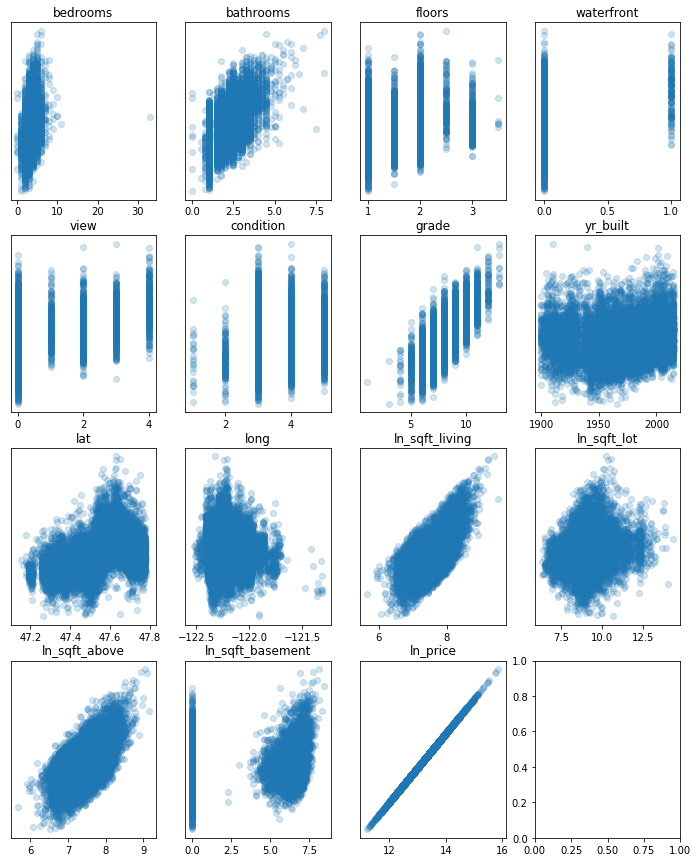

In [6]:
cols_int = ['bedrooms','bathrooms','floors',
            'waterfront','view',
            'condition','grade',
            'yr_built',## 'yr_renovated',
            'lat', 'long',  
            'ln_sqft_living',## 'ln_sqft_living15', 
            'ln_sqft_lot',## 'ln_sqft_lot15',
            'ln_sqft_above','ln_sqft_basement']

mass_scatter(house_train[cols_int + ['ln_price']])

### Observation
#### Outliers
1. There is one outlier that has extremely many bedroom. 
2. Some price points are very high and weakening relationships, we should take a look at them.
3. There's a very large lot in the data set. We should check that's not an outlier.

#### Missing Info
1. Location is a valuable information. We have zipcode and long/lat to approximate the location info. 
- Add zipcode in as categorical and filter out to ones that matter. 
- Make an interaction of long/lat as a feature
2. Year renovated is perhaps important feature but is not applicable for most datapoints. We should create a new variable 'year_old' that counts the age of the house. Check interaction of this with Condition variable.
3. Basement - it seems like many are missing basement value. So I'll create a binary column for whether basement exist or not and add in as a feature.

### Outliers
#### 1. too many bedroom
There's a house with 30+ bedrooms. Let's take a look at that.

In [7]:
house_train[house_train.bedrooms > 20]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,ln_price,ln_sqft_living,ln_sqft_living15,ln_sqft_lot,ln_sqft_lot15,ln_sqft_above,ln_sqft_basement
8597,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,...,-122.331,1330,4700,13.369223,7.390181,7.192934,8.699515,8.455318,6.946976,6.363028


It's likely that 33 bedrooms is an input error of 3, since it's a small place with less than 2 bathrooms. We will change that value to more appropriate number.

In [8]:
round((house_train.bedrooms/house_train.sqft_living).median()*1620)

# median # of bedroom per sqft.living multiplied by sqft.living 
house_train.at[8597, 'bedrooms'] = 3

#### 2. Price outliers
Some houses seem to be extremely expensive. Let's take a look.

#### Price distribution

In [9]:
#house_train.boxplot(['price']) 

# some extreme values.
#   EB:  "Maybe we should remove them."
#   EMW: "No way, Jose!  Take logs instead."

In [10]:
#house_train.sort_values(by = 'price', ascending = False)

#### Log Price distribution  

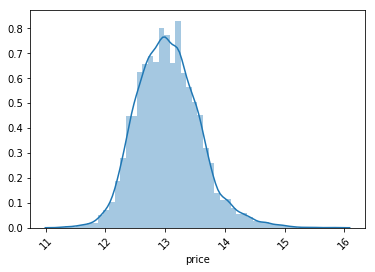

In [11]:
sns.distplot(np.log(house_train.price))
plt.xticks(rotation=45)
plt.show()

In [12]:
# removing outliers with log price value higher than 4 log std.
#log_filt = np.log(house_train.price).mean() + np.log(house_train.price).std()*4
#print(len(house_train[np.log(house_train.price)>= log_filt]))

# not removing it, but here's how to do it:
# house_train = house_train[np.log(house_train.price) < log_filt]

### 3. Large lot

In [13]:
#house_train.sort_values(by = 'sqft_lot', ascending = False)
# it seems like it's a large lot and a very small house. 
# I have no evidence to think this is an error. 
# We will keep it for now.

### Features (New columns)
Now I'll create new columns I need. From here on, I will need to be able to replicate, so I'll create them as a function.

#### Date
I'm not entirely sure what 'date' columns is supposed to be. But we can separate out month and year and see if they have any effect on our model.

In [14]:
def make_dates(df):
    df['month_sold'] = df.date.apply(lambda x: int(x[4:6]))
    df['yr_sold'] = df.date.apply(lambda x: int(x[0:4]))
    df.date = df.date.apply(lambda x: int(x[0:8]))
    df.date = pd.to_datetime(df.date, format = "%Y%m%d")
    return df

house_train = make_dates(house_train)

In [15]:
# change date
# house_train.date = pd.to_datetime(house_train.date, format = "%Y%m%d")

#### Year_old
Either year since renovated or since built

In [16]:
def make_yearold (df):
    df['year_old'] = np.where(df.yr_renovated == 0, df.yr_sold - df.yr_built, df.yr_sold - df.yr_renovated)
    return df
house_train = make_yearold(house_train)

#### Basement
Add a column that shows whether there is a basement or not. 

In [17]:
def make_basement(df):
    df['basement'] = np.where(df.sqft_basement > 0, 1, 0)
    return df

house_train = make_basement(house_train)

## Status Check

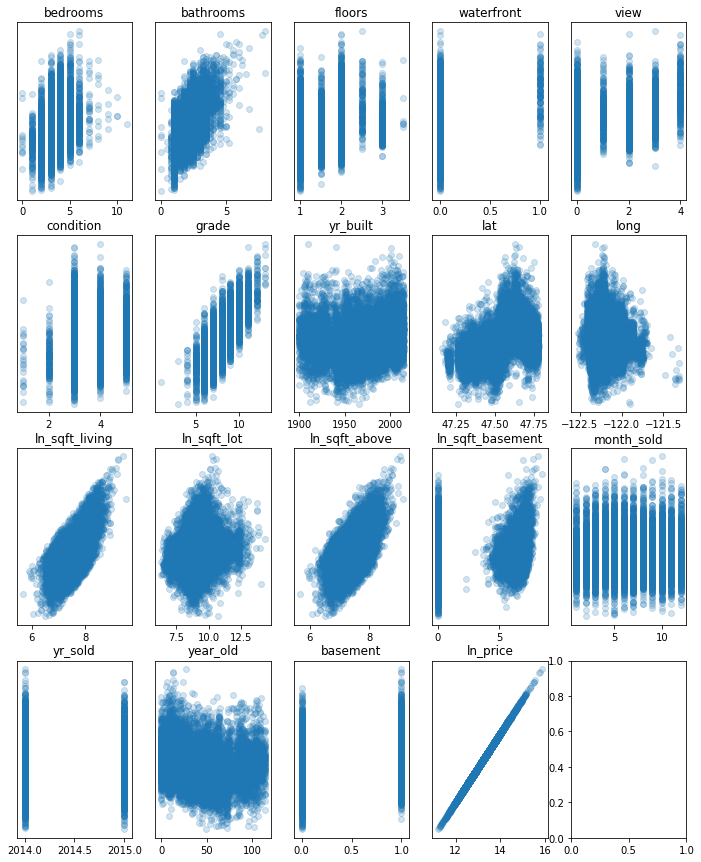

In [18]:
##  columns of interest
cols_int = ['bedrooms','bathrooms','floors',
            'waterfront','view',
            'condition','grade',
            'yr_built',## 'yr_renovated',
            'lat', 'long',  
            'ln_sqft_living',## 'ln_sqft_living15', 
            'ln_sqft_lot',## 'ln_sqft_lot15',
            'ln_sqft_above','ln_sqft_basement',
            'month_sold','yr_sold','year_old','basement']

mass_scatter(house_train[cols_int + ['ln_price']])

## Baseline Model

We will check for assumptions and create a baseline model here. And then we will investigate interactions and other feature selection to see if any improves our model.

### Scale, transform data, and add dummy columns

In [19]:
# sqft_lot seemed to have exponential decay relationship to price. So transferring to log.
# Can't say with confidence that this is linear relationship...???
#plt.scatter(np.log(house_train.ln_sqft_lot), house_train.ln_price, alpha = 0.2);

In [20]:
def dummies(x, prefix):
    """
    Helper function to make dummies
    Input: series or array, prefix string
    Output: dummy dataframe
    """
    dummy = pd.get_dummies(x, prefix = prefix, drop_first = True)
    return dummy

In [21]:
def standardize(x):
    """
    Helper function to standardize scalar values
    Input: series or numpy array 
    Output: original input as standardized version ((x-mean(x))/std(x))
    """
    return (x - x.mean())/x.std()

In [22]:
def remove_feat(df, exc_list):
    df.drop(exc_list, axis = 1, inplace = True)
    return df

In [23]:
##  turn categorical variables into dummy variables
zp_df = dummies(house_train['zipcode'],'zip')
mo_df = dummies(house_train['month_sold'],'mo_sold')
yr_df = dummies(house_train['yr_sold'],'yr_sold')

# ##  add them to dataframe
house_train = house_train.join(zp_df)
house_train = house_train.join(mo_df)
house_train = house_train.join(yr_df)

# ##  get lists of variable names
zp_dummies = list(zp_df.columns)
mo_dummies = list(mo_df.columns)
yr_dummies = list(yr_df.columns)

### Check for multicollinearity

In [24]:
def corr_high(df):
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['var1', 'var2', 'corr']
    return corr_df[(corr_df['corr'] > 0.6) & (corr_df['corr'] < 1)].sort_values(by = 'corr', ascending = False)

In [25]:
cols_int = ['bedrooms','bathrooms','floors',
            'waterfront','view',
            'condition','grade',
            'yr_built',
            'lat', 'long',  
            'ln_sqft_living',
            'ln_sqft_lot',
            'ln_sqft_above','ln_sqft_basement']

corr_high(house_train[cols_int])

,var1,var2,corr
152,ln_sqft_living,ln_sqft_above,0.864497
178,ln_sqft_above,ln_sqft_living,0.864497
24,bathrooms,ln_sqft_living,0.761053
141,ln_sqft_living,bathrooms,0.761053
96,grade,ln_sqft_above,0.745496
174,ln_sqft_above,grade,0.745496
94,grade,ln_sqft_living,0.744542
146,ln_sqft_living,grade,0.744542
26,bathrooms,ln_sqft_above,0.694596
169,ln_sqft_above,bathrooms,0.694596


### Remove features

In [26]:
##  Why remove anything?  Just ignore it!  
#exc_list = ['sqft_living', 'sqft_lot15', 'sqft_living15', 'con_4']
#X = remove_feat(X, exc_list)

### Run baseline model


In [27]:
cols_int = ['bedrooms','bathrooms','floors','basement',
            'waterfront','view',
            'condition','grade',
            'yr_built',
            'lat', 'long',  
            'ln_sqft_living',
            'ln_sqft_lot']#,
            #'ln_sqft_basement']
#cols_int = cols_int + zp_dummies

m01_fmla = 'ln_price~' + '+'.join(cols_int)
m01_ols = ols(m01_fmla,data=house_train).fit()
m01_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     4310.
Date:                Sat, 25 Jul 2020   Prob (F-statistic):               0.00
Time:                        18:29:34   Log-Likelihood:                -958.00
No. Observations:               17290   AIC:                             1944.
Df Residuals:                   17276   BIC:                             2053.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -41.7957      2.305    -18.129      0.000     -46.315     -37.277
bedrooms          -0.0281      0.003     -9.723      0.000      -0.034      -0.022
bathrooms          0.0712      0.005     15.698      0.000       0.062       0.080
floors             0.0506      0.005      9.555      0.000       0.040       0.061
basement           0.0052      0.005      1.040      0.298      -0.005       0.015
waterfront         0.3933      0.024     16.370      0.000       0.346       0.440
view               0.0707      0.003     24.114      0.000       0.065       0.076
condition          0.0547      0.003     16.806      0.000       0.048       0.061
grade              0.1853      0.003     65.781      0.000       0.180       0.191
yr_built          -0.0038   9.61e-05    -39.270      0.000      -0.004      -0.004
lat                1.3414      0.015     89.711      0.000       1.312       1.371
long               0.0519      0.017      3.037      0.002       0.018       0.085
ln_sqft_living     0.4123      0.010     39.852      0.000       0.392       0.433
ln_sqft_lot       -0.0049      0.003     -1.736      0.083      -0.010       0.001
==============================================================================
Omnibus:                      445.117   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              903.190
Skew:                           0.164   Prob(JB):                    7.50e-197
Kurtosis:                       4.071   Cond. No.                     2.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interactions

I think there is a relationship between condition and year_old. Let's plot them to see if there's any interaction effect on price.

1. Condition & year_old
2. Waterfront & view

Before we begin, I'll see if there's any other interactions to use.

### Combining conditions
I'm going to combine condition 1, 2 and 3, 4, to add interaction between some of them and year_old without making too many features.

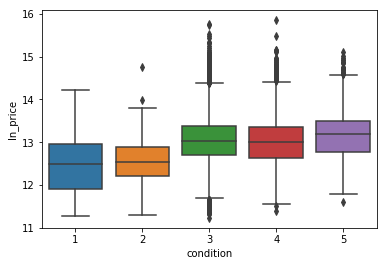

In [28]:
# I want to look closely how individual condition relationship to price.
# I want to combine some of these if their relationship is similar

plt.figure(figsize = (6, 4))
sns.boxplot(x = "condition", y = "ln_price", data = house_train);

# I think we can combine condition (1, 2), (3, 4), 5

In [29]:
# I'm flipping the numbers so it will drop the highest condition later.
house_train = house_train.copy()
house_train.condition = np.where((house_train.condition == 1) | (house_train.condition == 2), 3, 
                                 np.where(house_train.condition == 5, 2, 1))

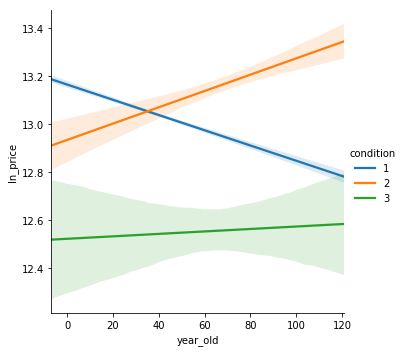

In [30]:
sns.lmplot(x="year_old", y="ln_price", hue="condition", 
           data=house_train, scatter = False);

It seems like when condition is high and medium, there's some interaction with it between years. We'll apply this after separating out the dummy variables.

In [31]:
# code from Learn.co turned to a function
from itertools import combinations

def find_interactions(X, y, baseline):
    interactions = []
    feature_comb = combinations(X.columns, 2) # all pairs
    data = X.copy()
    reg = LinearRegression()
    crossvalidation = KFold(n_splits = 10, shuffle = True, random_state = 1)

    for i, (a, b) in enumerate(feature_comb):
        data['interaction'] = data[a] * data[b]
        score = np.mean(cross_val_score(reg, data, y, scoring = 'r2', cv = crossvalidation))
        if score > baseline: 
            interactions.append((a, b, round(score, 3)))
        if i % 50 == 0: 
            print (i) # tally
    return interactions

In [32]:
# cols_int = ['bedrooms','bathrooms','floors',
#             'waterfront','view',
#             'condition','grade',
#             'yr_built',
#             'lat', 'long',  
#             'ln_sqft_living',
#             'ln_sqft_lot',
#             'ln_sqft_basement']
# ## cols_int = cols_int + zp_dummies

# xx = house_train[cols_int]
# yy = house_train['ln_price']

# bl = lin_avg_crossval(xx, yy)
# interactions = find_interactions(xx, yy, bl) 

In [33]:
# sorted(interactions, key = lambda inter: inter[2], reverse = True)

Additionally it seems like sqft seems to interact a lot with others.  
It's reasonable to believe that sqft_above and waterfront or existence of basement is interacting.  
We will add these top threes after reviewing their trendlines.

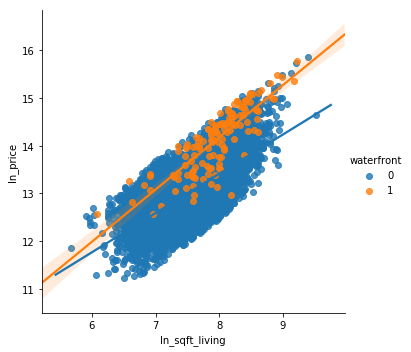

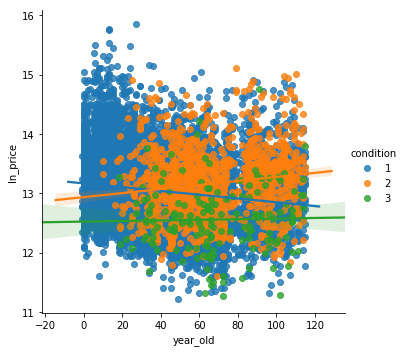

In [34]:
sns.lmplot(x="ln_sqft_living", y="ln_price", hue="waterfront", data=house_train);
plt.show()
#sns.lmplot(x="bathrooms", y="ln_price", hue="waterfront", data=house_train);
#plt.show()
sns.lmplot(x="year_old", y="ln_price", hue="condition", data=house_train);
plt.show()

###  some interactions

additional square feet of living space yields larger increase in price when property on `waterfront`

`year_old` increases price when `condition = 2` (less so when `condition = 3`), but decreases it when `condition = 1`

### Adding interaction

Add interaction between discussed measures.

In [35]:
print(house_train.columns[3:32])

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'ln_price', 'ln_sqft_living',
       'ln_sqft_living15', 'ln_sqft_lot', 'ln_sqft_lot15', 'ln_sqft_above',
       'ln_sqft_basement', 'month_sold', 'yr_sold', 'year_old', 'basement'],
      dtype='object')


In [36]:
# add interaction terms
house_train['cond1_x_year_old'] = np.where(house_train['condition']==1,1,0) * house_train['year_old']
house_train['water_x_lnsqftlv'] = house_train['ln_sqft_living'] * house_train['waterfront']

In [37]:
cols_int = ['bedrooms','bathrooms','floors','basement',
            'waterfront','view',
            'condition','grade',
            'yr_built',
            'lat', 'long',  
            'ln_sqft_living',
            'ln_sqft_lot',
            #'ln_sqft_basement',
            'cond1_x_year_old']#,
            #'water_x_lnsqftlv']
#cols_int = cols_int + zp_dummies

m02_fmla = 'ln_price~' + '+'.join(cols_int)
m02_ols = ols(m02_fmla,data=house_train).fit()
m02_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     3938.
Date:                Sat, 25 Jul 2020   Prob (F-statistic):               0.00
Time:                        18:29:57   Log-Likelihood:                -1063.9
No. Observations:               17290   AIC:                             2158.
Df Residuals:                   17275   BIC:                             2274.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -39.5663      2.317    -17.074      0.000     -44.108     -35.024
bedrooms            -0.0258      0.003     -8.854      0.000      -0.031      -0.020
bathrooms            0.0688      0.005     14.849      0.000       0.060       0.078
floors               0.0391      0.005      7.333      0.000       0.029       0.050
basement             0.0063      0.005      1.244      0.213      -0.004       0.016
waterfront           0.3873      0.024     16.013      0.000       0.340       0.435
view                 0.0713      0.003     24.163      0.000       0.066       0.077
condition            0.0038      0.010      0.388      0.698      -0.015       0.023
grade                0.1852      0.003     65.275      0.000       0.180       0.191
yr_built            -0.0046      0.000    -33.081      0.000      -0.005      -0.004
lat                  1.3316      0.015     88.543      0.000       1.302       1.361
long                 0.0515      0.017      2.992      0.003       0.018       0.085
ln_sqft_living       0.4167      0.010     40.014      0.000       0.396       0.437
ln_sqft_lot         -0.0044      0.003     -1.528      0.126      -0.010       0.001
cond1_x_year_old    -0.0007      0.000     -5.005      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      418.897   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              906.438
Skew:                           0.114   Prob(JB):                    1.48e-197
Kurtosis:                       4.098   Cond. No.                     2.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
# interaction didn't explain much. 
m01_r2 = m01_ols.rsquared 
m02_r2 = m02_ols.rsquared

print('R^2 m01:  ' +str(round(m01_r2,4)))
print('R^2 m02:  ' +str(round(m02_r2,4)))

R^2 m01:  0.7643
R^2 m02:  0.7614


In [39]:
cols_int = ['bedrooms','bathrooms','floors','basement',
            'waterfront','view',
            'condition','grade',
            'yr_built',
            'lat', 'long',  
            'ln_sqft_living',
            'ln_sqft_lot']#,
            #'ln_sqft_basement',
            #'cond1_x_year_old']#,
            #'water_x_lnsqftlv']
cols_int = cols_int + zp_dummies

m03_fmla = 'ln_price~' + '+'.join(cols_int)
m03_ols = ols(m03_fmla,data=house_train).fit()

In [40]:
#m03_ols.summary()

In [41]:
# adding zipcodes helps
m03_r2 = m03_ols.rsquared

print('R^2 m01:  ' +str(round(m01_r2,4)))
print('R^2 m02:  ' +str(round(m02_r2,4)))
print('R^2 m03:  ' +str(round(m03_r2,4)))

R^2 m01:  0.7643
R^2 m02:  0.7614
R^2 m03:  0.8781


In [42]:
# print(m01_fmla)
# print(m02_fmla)
# print(m03_fmla)

## non-linear transformation
Lat & Long are  not linear relationship. Let's see if we can transform these dataset.

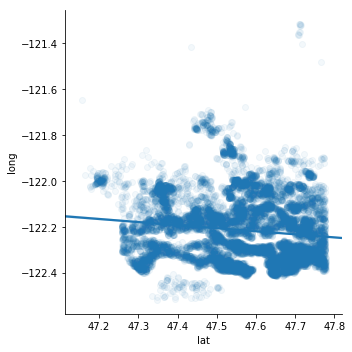

In [43]:
sns.lmplot(x = 'lat', y = 'long', data = house_train, scatter_kws = {'alpha': 0.05});
# it seems like there's some kind of clusters here. Maybe use clustering method?

In [44]:
location = list(zip(house_train['lat'], house_train['long']))
km = KMeans(n_clusters = 19, random_state = 0).fit(location)

X3 = house_train.copy()
X3['km_location'] = km.labels_

In [45]:
center = km.cluster_centers_

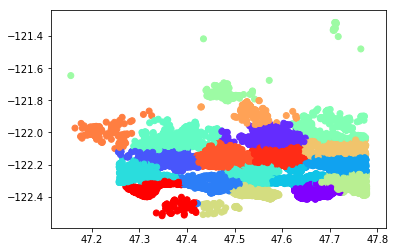

In [46]:
plt.scatter(X3['lat'],X3['long'], c=km.labels_, cmap='rainbow');

Let's see if there are significant differences in their price to use this in the model.

How do we generalize...?
Maybe we can save the centroids and use them as initial centroids and don't iterate...?

In [47]:
dummy = dummies(X3['km_location'], 'kml')
X3 = pd.concat([X3, dummy], axis = 1)

Testing the model again

In [48]:
def lin_avg_crossval(X, y):
    regression = LinearRegression()
    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
    
    return np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

def lin_fit(X, y):
    lm = LinearRegression(normalize = True)
    lm = lm.fit(X, y)

    print(f"R2: {lm.score(X, y)}")
    print(f"Adj_R2: {1 - (1-lm.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)}")

    return lm

In [49]:
cols_int = ['bedrooms','bathrooms','floors','basement',
            'waterfront','view',
            'condition','grade',
            'yr_built',
            'lat', 'long',  
            'ln_sqft_living',
            'ln_sqft_lot']
cols_int = cols_int + zp_dummies

In [50]:
# Find the best number of n_clusters
max_ = 0
for i in range(2,30):
    location = list(zip(house_train['lat'], house_train['long']))
    km = KMeans(n_clusters = i, random_state = 0).fit(location)
    xx = house_train[cols_int]
    yy = house_train['ln_price']
    xx['km_location'] = km.labels_
    sc = lin_avg_crossval(xx, yy)
    if  sc > max_:
        max_ = sc
        print(f"{i}: {sc}")

2: 0.8763693938345684
3: 0.8765048778761338
8: 0.8766073323133732
19: 0.8766200026754035
20: 0.877325466320008


In [51]:
best_n_means = 20
location = list(zip(house_train['lat'], house_train['long']))
km = KMeans(n_clusters = best_n_means, random_state = 0).fit(location)
X3 = house_train[cols_int]
yy = house_train['ln_price']
X3['km_location'] = km.labels_


print('improved R^2')
print('R^2 baseline:  ' + str(round(lin_avg_crossval(house_train[cols_int], house_train['ln_price']),4)))
print('R^2 with KMC:  ' + str(round(lin_avg_crossval(X3, house_train['ln_price']),4)))

improved R^2
R^2 baseline:  0.8763
R^2 with KMC:  0.8773


In [52]:
model_KNN = lin_fit(X3,yy)

R2: 0.8790995140609332
Adj_R2: 0.8785163023712352


## Step 5: Train Test Split

If you plan on doing any sclaing of your data, make sure it is doen at the apporpriate time. 

Since we will be re-running this process again, I'll write it as a function.  

### 5.1) Perform a train test split of the data.

In [53]:
# function to split the data 
def split_df (X, y, test_size = 0.25, random_state = 42):
    """
    input: df and name of outcome column
    return: train, test for x and y
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

### 5.4) Fit the model to the training data.

In [54]:
def test_train_split(X, y, test_size = 0.25, random_state = 42):
    """
    split the data and fit model
    return y_train, y_test, y_pred_train, y_pred_test, print prediction errors
    """
    X_train, X_test, y_train, y_test = split_df(X, y, test_size, random_state)
    linreg = LinearRegression()

    linreg.fit(X_train, y_train)
        
    y_pred_train = linreg.predict(X_train)
    y_pred_test = linreg.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    print('Train RMSE:', np.sqrt(train_mse))
    print('Test RMSE:', np.sqrt(test_mse))

    return X_train, X_test, y_train, y_test, y_pred_train, y_pred_test

In [55]:
x_train, x_test, y_train, y_test, y_pred_train, y_pred_test = test_train_split(X3, yy)

Train RMSE: 0.1854178211433209
Test RMSE: 0.1768598261173649


### 5.7) Determine if your model is overfit.

Text(0.5, 0, 'RMSE')

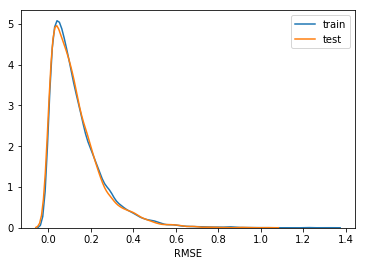

In [56]:
sns.distplot(np.sqrt((y_train-y_pred_train)**2), hist = False, label = 'train')
sns.distplot(np.sqrt((y_test-y_pred_test)**2), hist = False, label = 'test')
plt.xlabel("RMSE")

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# if above 10 VIF - you should consider dropping this feature. 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif["features"] = X3.columns
vif.round(1)

,VIF Factor,features
0,27.6,bedrooms
1,28.0,bathrooms
2,21.1,floors
3,2.8,basement
4,1.3,waterfront
5,1.6,view
6,13.3,condition
7,145.2,grade
8,12211.9,yr_built
9,6153476.4,lat


In [58]:
rmfeats = vif[(vif['VIF Factor'] != np.inf) & (vif['VIF Factor'] > 10)].sort_values(by = "VIF Factor", ascending = False).features

In [59]:
rmfeats

9                lat
10              long
8           yr_built
11    ln_sqft_living
12       ln_sqft_lot
7              grade
1          bathrooms
0           bedrooms
2             floors
82       km_location
40         zip_98052
34         zip_98034
6          condition
41         zip_98053
74         zip_98155
61         zip_98115
69         zip_98133
54         zip_98103
49         zip_98074
33         zip_98033
63         zip_98117
67         zip_98125
48         zip_98072
Name: features, dtype: object

In [60]:
X3a = X3.drop(rmfeats, axis = 1)

In [61]:
## Code from Learn.co
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [62]:
result = stepwise_selection(X3, yy, verbose=True)
print('resulting features:')
print(result)

Add  lat                            with p-value 0.0
Add  ln_sqft_living                 with p-value 0.0
Add  km_location                    with p-value 0.0
Add  grade                          with p-value 0.0
Add  view                           with p-value 0.0
Add  yr_built                       with p-value 2.00969e-195
Add  zip_98004                      with p-value 1.8221e-165
Add  zip_98040                      with p-value 2.25273e-121
Add  waterfront                     with p-value 9.6225e-90
Add  zip_98112                      with p-value 1.9048e-86
Add  zip_98039                      with p-value 9.30328e-77
Add  zip_98027                      with p-value 3.04911e-63
Add  zip_98033                      with p-value 5.77184e-62
Add  zip_98029                      with p-value 5.28821e-63
Add  zip_98115                      with p-value 2.29915e-62
Add  zip_98023                      with p-value 5.40092e-62
Add  zip_98075                      with p-value 7.3488e-58
Add 

In [63]:
X3b = X3[result]

In [64]:
len(result)

72

In [65]:
#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=60)
selector = selector.fit(X3, yy)
X3.columns[selector.support_]

Index(['waterfront', 'view', 'grade', 'lat', 'ln_sqft_living', 'ln_sqft_lot',
       'zip_98004', 'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008',
       'zip_98010', 'zip_98011', 'zip_98022', 'zip_98024', 'zip_98027',
       'zip_98028', 'zip_98029', 'zip_98033', 'zip_98034', 'zip_98038',
       'zip_98039', 'zip_98040', 'zip_98045', 'zip_98052', 'zip_98053',
       'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98065',
       'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077',
       'zip_98102', 'zip_98103', 'zip_98105', 'zip_98106', 'zip_98107',
       'zip_98108', 'zip_98109', 'zip_98112', 'zip_98115', 'zip_98116',
       'zip_98117', 'zip_98118', 'zip_98119', 'zip_98122', 'zip_98125',
       'zip_98126', 'zip_98133', 'zip_98136', 'zip_98144', 'zip_98146',
       'zip_98155', 'zip_98166', 'zip_98177', 'zip_98199'],
      dtype='object')

In [66]:
X3c = X3[X3.columns[selector.support_]]

In [67]:
print(lin_fit(X3, yy))
print()
print(lin_fit(X3a, yy))
print()
print(lin_fit(X3b, yy))
print()
print(lin_fit(X3c, yy))

R2: 0.8790995140609332
Adj_R2: 0.8785163023712352
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

R2: 0.5626991807787988
Adj_R2: 0.5611762804854984
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

R2: 0.8786536914183841
Adj_R2: 0.8781462316856853
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

R2: 0.8737652943822565
Adj_R2: 0.8733256819649912
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [68]:
corr_high(X3)

,var1,var2,corr
94,bathrooms,ln_sqft_living,0.761053
914,ln_sqft_living,bathrooms,0.761053
592,grade,ln_sqft_living,0.744542
920,ln_sqft_living,grade,0.744542
90,bathrooms,grade,0.664191
582,grade,bathrooms,0.664191
11,bedrooms,ln_sqft_living,0.633862
913,ln_sqft_living,bedrooms,0.633862


### Comparing MSE

Train RMSE: 0.1854178211433209
Test RMSE: 0.1768598261173649


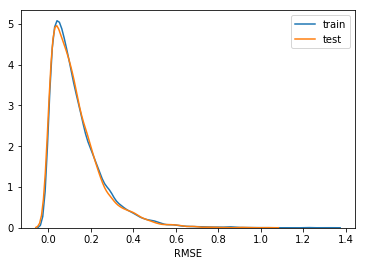

In [69]:
Xs = [ X3 ]

for x in Xs:
    x_tr, x_te, y_train, y_test, y_pred_train, y_pred_test = test_train_split(x, yy)
    sns.distplot(np.sqrt((y_train-y_pred_train)**2), hist = False, label = 'train')
    sns.distplot(np.sqrt((y_test-y_pred_test)**2), hist = False, label = 'test')
    plt.xlabel("RMSE")
    plt.show()

Train RMSE: 0.1854178211433209
Test RMSE: 0.1768598261173649
TRAIN
R2: 0.8765880390380243
Adj_R2: 0.8757929452896859
TEST
R2: 0.888713919640703
Adj_R2: 0.8865349282111626


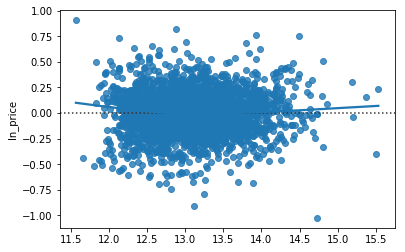

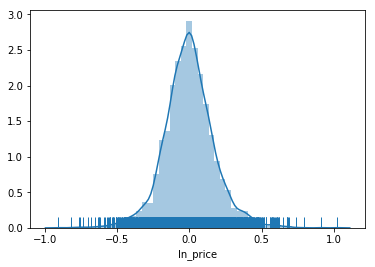

NormaltestResult(statistic=212.98680104156568, pvalue=5.629940366149388e-47)
NormaltestResult(statistic=1130.549264333681, pvalue=3.1940851528616745e-246)
[('Jarque-Bera', 710.9532646002939), ('Prob', 4.153939304173643e-155), ('Skew', 0.13709448503249336), ('Kurtosis', 4.967694030023121)]


In [70]:
from statsmodels.stats.stattools import jarque_bera
for x in Xs:
    x_train, x_test, y_train, y_test, y_pred_train, y_pred_test = test_train_split(x, yy)
    print("TRAIN")
    lm = lin_fit(x_train, y_train) 
    print("TEST")
    lm = lin_fit(x_test, y_test)
    
    # look at variance
    sns.residplot(y_pred_test, y_test, lowess = True)
    plt.show()
    
    #normality
    sns.distplot((y_pred_test - y_test), kde = True, rug = True)
    plt.show()

    print(st.normaltest(y_pred_test - y_test))
    print(st.normaltest(y_pred_train - y_train))

    name = ['Jarque-Bera', 'Prob', 'Skew', 'Kurtosis']
    test = jarque_bera(y_pred_test - y_test)
    print(list(zip(name, test)))


## Step 7: Evaluate your different models in order to determine the best model overall

Train RMSE: 0.1854178211433209
Test RMSE: 0.1768598261173649


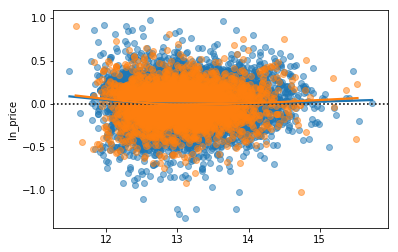

In [71]:
X_train, X_test, y_train, y_test, y_pred_train, y_pred_test = test_train_split(X3, yy)

sns.residplot(y_pred_train, y_train, lowess = True, scatter_kws = {'alpha':0.5})
sns.residplot(y_pred_test, y_test, lowess = True, scatter_kws = {'alpha':0.5})


It's not overfitting, but it does seem like residuals are heteroscedastic.

## Step 8:  Refit your best model to the entire dataset

In [72]:
model = lin_fit(X3, yy)

R2: 0.8790995140609332
Adj_R2: 0.8785163023712352


## Step 9: Save your final model using pickle

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [73]:
filename = 'model_eb-emw-v3.sav'
pickle.dump(model, open(filename, 'wb'))